### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import HTML

plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys
import math

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

In [5]:
# point at library; I need some lessons on doing good PYTHONPATHs:
from codit import share_dir
DATA_PATH = os.path.join(share_dir(), 'codit', 'data')
#REPO_DIR = os.path.dirname(os.getcwd())
#sys.path.append(os.path.join(REPO_DIR, 'lib'))
#DATA_PATH = os.path.join(REPO_DIR, 'data')

# Covid epidemic simulator

In [6]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.population.covid import PersonCovid
import codit.society as society
import codit.config

from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import POPULATION_LEEDS

### Baseline config of the simulation

In [7]:
codit.config.print_baseline_config()

DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY 0.025
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We are going to work with a small town of a few thousand people.

In [8]:
pop = CityPopulation(POPULATION_LEEDS, society.Society(), person_type=PersonCovid)

2021-01-28 17:55:29,266 INFO:Building a set of 317255 households from which to build a population
2021-01-28 17:55:34,247 INFO:There are 317255 households generated for accommodation buildings
2021-01-28 18:06:35,003 INFO:306605 households of mean size 2.59
2021-01-28 18:06:35,595 INFO:Only putting children >12 years old into classrooms.
2021-01-28 18:06:35,741 INFO:1896 classrooms of mean size 30.95
2021-01-28 18:06:35,994 INFO:111 care_homes of mean size 105.32
2021-01-28 18:06:36,829 INFO:94793 workplaces of mean size 5.58
2021-01-28 18:06:36,888 INFO:Adding 403405 permanent contact groups
2021-01-28 18:06:36,998 INFO:Adding 39657 ephemeral contact pairs


Randomly, we put them into fixed and overlapping social groupings, where each person has a small network.

In [9]:
nets = [len(p.contacts) for p in pop.people]

In [10]:
np.mean(nets)

12.934971045428355

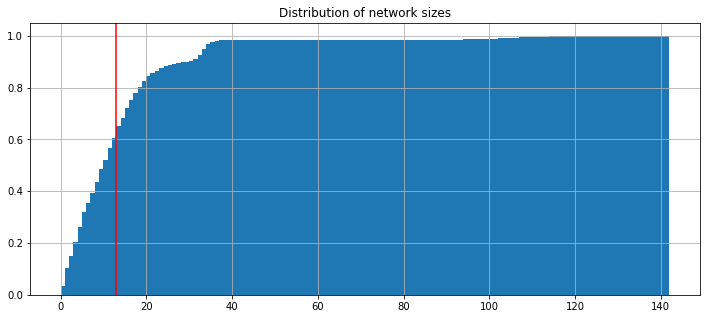

In [11]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [12]:
POP_SIZE = POPULATION_LEEDS
PREVALENCE = 1/560 * 4
SCALE_SETTINGS = dict(n_days = 201, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 201,
 'pop_size': 793139,
 'seed_size': 5665,
 'population': <codit.population.networks.city.CityPopulation at 0x7fe53591bf10>}

Our baseline simulation is of a runaway infection.

In [13]:
f"We start with {int(POP_SIZE*PREVALENCE)} people infected in a population of {POPULATION_LEEDS}."

'We start with 5665 people infected in a population of 793139.'

We begin by studying a society where people don't know whether or how to self-isolate:

In [14]:
s_basic = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0))
o_basic = Outbreak(s_basic, Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:06:53,609 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:07:08,952 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-01-28 18:07:19,693 INFO:Day 8, prop infected is 0.03, prop infectious is 0.0104
2021-01-28 18:07:31,938 INFO:Day 15, prop infected is 0.06, prop infectious is 0.0268
2021-01-28 18:07:43,796 INFO:Day 22, prop infected is 0.11, prop infectious is 0.0373
2021-01-28 18:07:56,108 INFO:Day 29, prop infected is 0.17, prop infectious is 0.0540
2021-01-28 18:08:09,405 INFO:Day 36, prop infected is 0.26, prop infectious is 0.0735
2021-01-28 18:08:23,683 INFO:Day 43, prop infected is 0.34, prop infectious is 0.0863
2021-01-28 18:08:37,660 INFO:Day 50, prop infected is 0.42, prop infectious is 0.0830
2021-01-28 18:08:50,722 INFO:Day 57, prop infected is 0.47, prop infectious is 0.0675
2021-01-28 18:09:03,094 INFO:Day 64, prop infected is 0.51, prop infectious is 0.0482
2021-01-28 18:09:14,653 INFO:Day 7

2021-01-28 18:12:27,099 INFO: Realized R0 of early infections is 1.49
2021-01-28 18:12:27,100 INFO: 56.9 percent of the proportion was infected during the epidemic


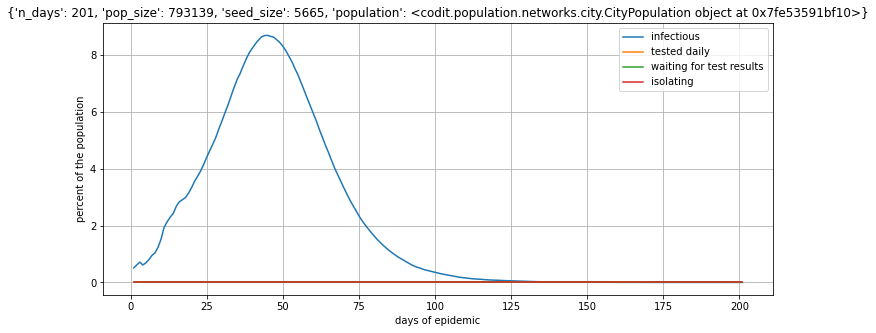

In [15]:
o_basic.plot(title=str(SCALE_SETTINGS))

Lets put that on a log scale:

2021-01-28 18:12:27,350 INFO: Realized R0 of early infections is 1.49
2021-01-28 18:12:27,350 INFO: 56.9 percent of the proportion was infected during the epidemic


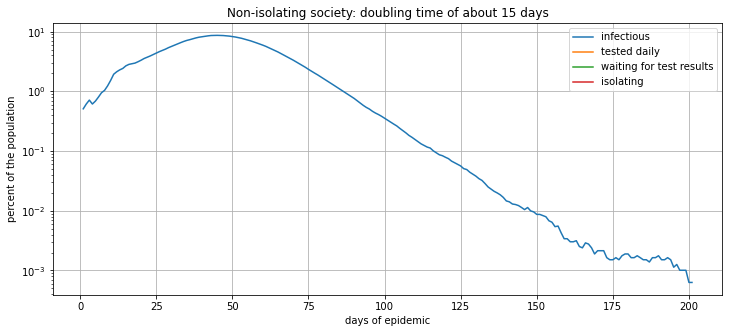

In [16]:
o_basic.plot(logy=True, title='Non-isolating society: doubling time of about 15 days')

In [17]:
animation = o_basic.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','no_isolation.mp4'), dpi=o_basic.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:12:28,097 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:12:28,100 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/no_isolation.mp4
2021-01-28 18:12:36,355 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:12:36,357 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmphc4t95pz/temp.m4v


Next, suppose that people know to isolate if they show symptoms, and 75% do so - this is similar to what is going on in the UK now:

In [18]:
s_isolate = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0.75))
o_isolate = Outbreak(s_isolate, Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:12:44,454 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:12:59,990 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-28 18:13:10,978 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0076
2021-01-28 18:13:22,768 INFO:Day 15, prop infected is 0.04, prop infectious is 0.0156
2021-01-28 18:13:34,412 INFO:Day 22, prop infected is 0.05, prop infectious is 0.0137
2021-01-28 18:13:46,079 INFO:Day 29, prop infected is 0.07, prop infectious is 0.0151
2021-01-28 18:13:57,638 INFO:Day 36, prop infected is 0.08, prop infectious is 0.0165
2021-01-28 18:14:09,232 INFO:Day 43, prop infected is 0.10, prop infectious is 0.0184
2021-01-28 18:14:21,425 INFO:Day 50, prop infected is 0.12, prop infectious is 0.0198
2021-01-28 18:14:33,418 INFO:Day 57, prop infected is 0.14, prop infectious is 0.0201
2021-01-28 18:14:45,154 INFO:Day 64, prop infected is 0.16, prop infectious is 0.0196
2021-01-28 18:14:57,302 INFO:Day 7

2021-01-28 18:18:29,243 INFO: Realized R0 of early infections is 1.15
2021-01-28 18:18:29,244 INFO: 27.4 percent of the proportion was infected during the epidemic


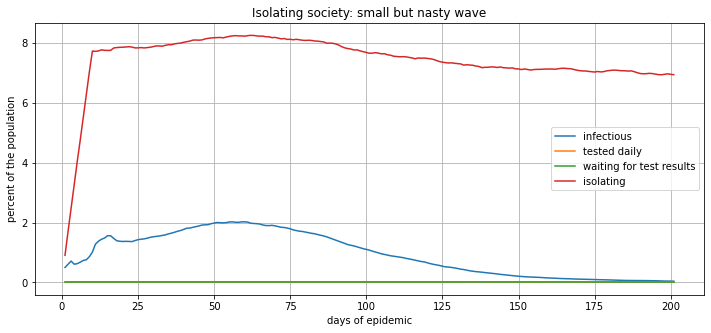

In [19]:
o_isolate.plot(title='Isolating society: small but nasty wave')

In [20]:
animation = o_isolate.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','some_isolation.mp4'), dpi=o_isolate.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:18:29,583 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:18:29,585 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/some_isolation.mp4
2021-01-28 18:18:37,848 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:18:37,850 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp83ux_hrg/temp.m4v


So, now we can add testing:
 * initially, here, lets suppose that positive test results are just ignored, while -ve results let people out of isolation:

In [21]:
s_testignored = society.TestingSociety(config=dict(PROB_ISOLATE_IF_TESTPOS=0))
o_testignored = Outbreak(s_testignored, Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:18:45,841 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:19:02,551 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-01-28 18:19:15,786 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0075
2021-01-28 18:19:29,847 INFO:Day 15, prop infected is 0.04, prop infectious is 0.0159
2021-01-28 18:19:43,529 INFO:Day 22, prop infected is 0.05, prop infectious is 0.0150
2021-01-28 18:19:57,163 INFO:Day 29, prop infected is 0.07, prop infectious is 0.0177
2021-01-28 18:20:10,758 INFO:Day 36, prop infected is 0.10, prop infectious is 0.0210
2021-01-28 18:20:24,810 INFO:Day 43, prop infected is 0.12, prop infectious is 0.0242
2021-01-28 18:20:38,766 INFO:Day 50, prop infected is 0.15, prop infectious is 0.0264
2021-01-28 18:20:52,649 INFO:Day 57, prop infected is 0.18, prop infectious is 0.0277
2021-01-28 18:21:09,165 INFO:Day 64, prop infected is 0.20, prop infectious is 0.0272
2021-01-28 18:21:22,783 INFO:Day 7

2021-01-28 18:25:14,257 INFO: Realized R0 of early infections is 1.20
2021-01-28 18:25:14,258 INFO: 32.3 percent of the proportion was infected during the epidemic


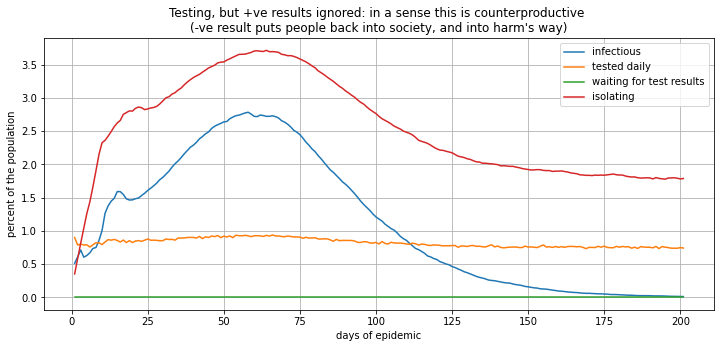

In [22]:
o_testignored.plot(title="Testing, but +ve results ignored: in a sense this is counterproductive \n"
                         "(-ve result puts people back into society, and into harm's way)")

In [23]:
animation = o_testignored.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','test_ignored.mp4'), dpi=o_testignored.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:25:14,623 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:25:14,626 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/test_ignored.mp4
2021-01-28 18:25:22,742 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:25:22,744 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpaj5p733q/temp.m4v


 * Now suppose that people respond to test results, some of the time:

In [24]:
o_test = Outbreak(society.TestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:25:30,742 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:25:45,519 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-01-28 18:25:58,715 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0073
2021-01-28 18:26:12,393 INFO:Day 15, prop infected is 0.03, prop infectious is 0.0144
2021-01-28 18:26:29,252 INFO:Day 22, prop infected is 0.05, prop infectious is 0.0137
2021-01-28 18:26:42,610 INFO:Day 29, prop infected is 0.07, prop infectious is 0.0161
2021-01-28 18:26:56,098 INFO:Day 36, prop infected is 0.09, prop infectious is 0.0188
2021-01-28 18:27:09,642 INFO:Day 43, prop infected is 0.11, prop infectious is 0.0209
2021-01-28 18:27:23,273 INFO:Day 50, prop infected is 0.13, prop infectious is 0.0229
2021-01-28 18:27:36,886 INFO:Day 57, prop infected is 0.16, prop infectious is 0.0241
2021-01-28 18:27:50,448 INFO:Day 64, prop infected is 0.18, prop infectious is 0.0239
2021-01-28 18:28:03,866 INFO:Day 7

2021-01-28 18:31:50,357 INFO: Realized R0 of early infections is 1.19
2021-01-28 18:31:50,358 INFO: 29.8 percent of the proportion was infected during the epidemic


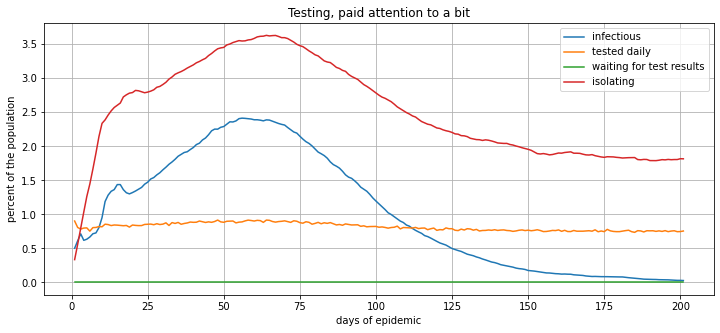

In [25]:
o_test.plot(title="Testing, paid attention to a bit")

In [26]:
animation = o_test.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','testandresponses.mp4'), dpi=o_test.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:31:50,697 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:31:50,699 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/testandresponses.mp4
2021-01-28 18:31:58,830 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:31:58,832 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo1se5yj5/temp.m4v


We add contact-tracing and isolation:

In [27]:
o_test_trace = Outbreak(society.TestingTracingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:32:06,833 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:32:22,178 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-01-28 18:32:34,751 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0074
2021-01-28 18:32:47,915 INFO:Day 15, prop infected is 0.03, prop infectious is 0.0116
2021-01-28 18:33:04,063 INFO:Day 22, prop infected is 0.04, prop infectious is 0.0079
2021-01-28 18:33:16,737 INFO:Day 29, prop infected is 0.04, prop infectious is 0.0075
2021-01-28 18:33:29,384 INFO:Day 36, prop infected is 0.05, prop infectious is 0.0070
2021-01-28 18:33:41,862 INFO:Day 43, prop infected is 0.06, prop infectious is 0.0059
2021-01-28 18:33:54,112 INFO:Day 50, prop infected is 0.06, prop infectious is 0.0053
2021-01-28 18:34:06,182 INFO:Day 57, prop infected is 0.07, prop infectious is 0.0047
2021-01-28 18:34:18,304 INFO:Day 64, prop infected is 0.07, prop infectious is 0.0043
2021-01-28 18:34:30,305 INFO:Day 7

2021-01-28 18:38:13,244 INFO: Realized R0 of early infections is 0.96
2021-01-28 18:38:13,245 INFO: 9.7 percent of the proportion was infected during the epidemic


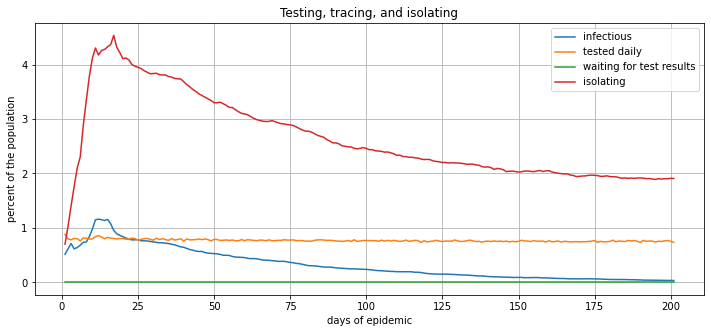

In [28]:
o_test_trace.plot(title='Testing, tracing, and isolating', secondary_y=['prop_infected'])

In [29]:
animation = o_test_trace.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','contact_tracing_isolation.mp4'), dpi=o_test_trace.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:38:13,570 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:38:13,572 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/contact_tracing_isolation.mp4
2021-01-28 18:38:21,809 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:38:21,811 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5aagcfa9/temp.m4v


UK society, however, is characterized by testing bottlenecks:

In [30]:
import codit.society.alternatives
o_UK = Outbreak(society.alternatives.UKSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:38:29,741 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:38:44,088 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-01-28 18:38:56,486 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0067
2021-01-28 18:39:09,520 INFO:Day 15, prop infected is 0.03, prop infectious is 0.0111
2021-01-28 18:39:25,441 INFO:Day 22, prop infected is 0.03, prop infectious is 0.0076
2021-01-28 18:39:38,225 INFO:Day 29, prop infected is 0.04, prop infectious is 0.0070
2021-01-28 18:39:51,098 INFO:Day 36, prop infected is 0.05, prop infectious is 0.0066
2021-01-28 18:40:03,975 INFO:Day 43, prop infected is 0.05, prop infectious is 0.0061
2021-01-28 18:40:16,877 INFO:Day 50, prop infected is 0.06, prop infectious is 0.0057
2021-01-28 18:40:29,909 INFO:Day 57, prop infected is 0.06, prop infectious is 0.0054
2021-01-28 18:40:42,484 INFO:Day 64, prop infected is 0.07, prop infectious is 0.0050
2021-01-28 18:40:55,112 INFO:Day 7

2021-01-28 18:44:47,626 INFO: Realized R0 of early infections is 0.97
2021-01-28 18:44:47,627 INFO: 11.5 percent of the proportion was infected during the epidemic


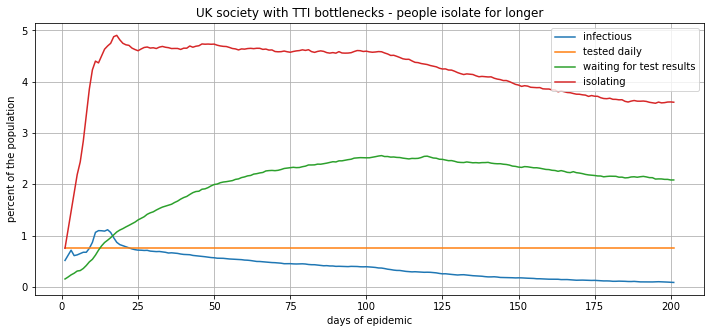

In [31]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

In [32]:
animation = o_UK.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','testing_bottleneck.mp4'), dpi=o_UK.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:44:47,996 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:44:47,998 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/testing_bottleneck.mp4
2021-01-28 18:44:55,944 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:44:55,946 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsmk9v88x/temp.m4v


In [33]:
o_contact_test = Outbreak(society.ContactTestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-01-28 18:45:03,997 WARNING:Using a pre-existing population - does it have the right network structure?
2021-01-28 18:45:19,200 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-01-28 18:45:33,066 INFO:Day 8, prop infected is 0.02, prop infectious is 0.0071
2021-01-28 18:45:50,655 INFO:Day 15, prop infected is 0.03, prop infectious is 0.0131
2021-01-28 18:46:05,927 INFO:Day 22, prop infected is 0.04, prop infectious is 0.0108
2021-01-28 18:46:21,982 INFO:Day 29, prop infected is 0.05, prop infectious is 0.0115
2021-01-28 18:46:39,324 INFO:Day 36, prop infected is 0.07, prop infectious is 0.0119
2021-01-28 18:46:56,870 INFO:Day 43, prop infected is 0.08, prop infectious is 0.0127
2021-01-28 18:47:13,991 INFO:Day 50, prop infected is 0.09, prop infectious is 0.0129
2021-01-28 18:47:31,575 INFO:Day 57, prop infected is 0.11, prop infectious is 0.0130
2021-01-28 18:47:48,960 INFO:Day 64, prop infected is 0.12, prop infectious is 0.0129
2021-01-28 18:48:06,301 INFO:Day 7

2021-01-28 18:53:03,157 INFO: Realized R0 of early infections is 1.09
2021-01-28 18:53:03,158 INFO: 20.8 percent of the proportion was infected during the epidemic


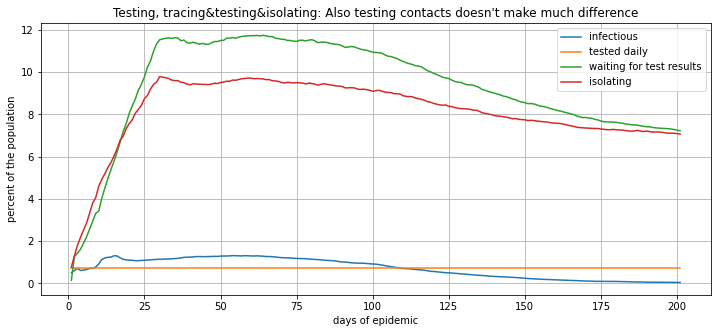

In [34]:
o_contact_test.plot(title="Testing, tracing&testing&isolating: "
                    "Also testing contacts doesn't make much difference", 
                    secondary_y=['prop_infected'])

In [35]:
animation = o_contact_test.camera.animate(interval=1000,repeat=False)
animation.save(os.path.join(DATA_PATH, 'city', 'population','contact_testings_tracing_isolation.mp4'), dpi=o_contact_test.fig.dpi)
HTML(animation.to_html5_video())

2021-01-28 18:53:03,502 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:53:03,504 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/justin.jia/work/CODiT/share/codit/data/city/population/contact_testings_tracing_isolation.mp4
2021-01-28 18:53:11,640 INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-01-28 18:53:11,642 INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2400x1000 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsdpsvaqt/temp.m4v


In [36]:
infector_nets = [len(p.infector.contacts) for p in pop.people if p.infector]

In [37]:
infected_nets = [len(p.contacts) for p in pop.people if p.infected]

In [38]:
def most_connected_infector(guy):
    if guy.infector is None:
        raise NotImplementedError
    return max([len(i.contacts) for i in guy.chain() if i is not guy]) 

max_contacts_chain = [most_connected_infector(person)
                      for person in pop.people 
                      if person.infector is not None]

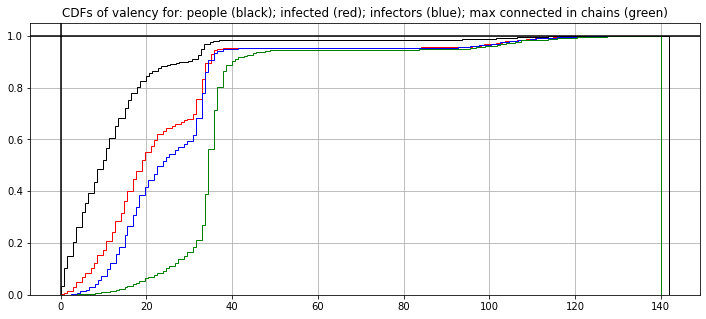

In [39]:
opts = dict(cumulative=True, bins=200, density=True, histtype='step')

plt.hist(nets, color='k', **opts)
plt.hist(infected_nets, color='r', **opts)
plt.hist(infector_nets, color='b', **opts)
plt.hist(max_contacts_chain, color='g', **opts)

plt.title("CDFs of valency for: people (black); infected (red); infectors (blue); max connected in chains (green)")
plt.axhline(1, color='k'); plt.axvline(0, color='k')
plt.grid()

In [40]:
coord = [[p.home.coordinate['lon'], p.home.coordinate['lat']] for p in pop.people if p.infected]
coord_column_list = list(zip(*coord))

<Figure size 864x360 with 0 Axes>

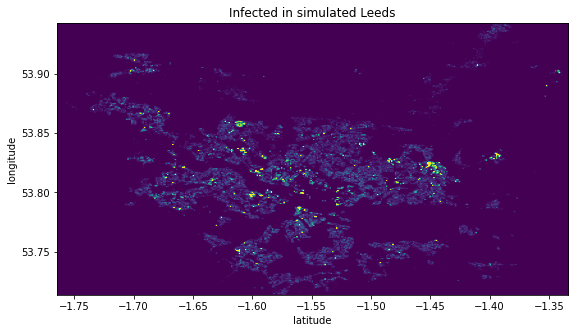

In [41]:

heatmap, xedges, yedges = np.histogram2d(coord_column_list[0], coord_column_list[1], bins=400)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.clf()
fig = plt.figure()
plt.title('Infected in simulated Leeds')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.imshow(heatmap.T, extent=extent, origin='lower', vmin=0, vmax=50)
plt.show()
fig.savefig(os.path.join(DATA_PATH, 'city','population','infected_heatmap.png'), dpi=fig.dpi)


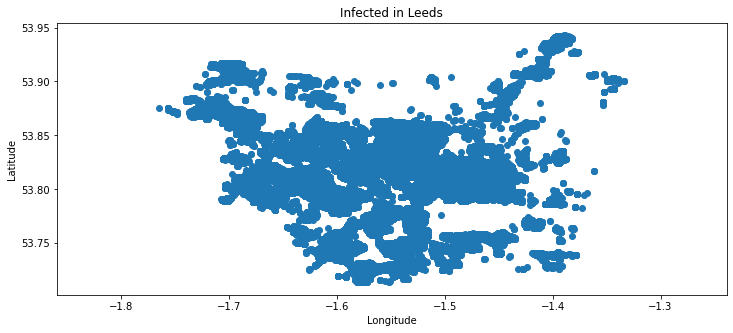

In [42]:
plt.plot(coord_column_list[0], coord_column_list[1], 'o')
plt.title('Infected in Leeds')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()